<a href="https://colab.research.google.com/github/Tar-ive/STOCKS/blob/code/Stock_Prediction_using_ADA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
!pip install ta

In [42]:
!pip install yfinance

In [43]:
!pip install quantstats

In [44]:

import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.ticker as mtick
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# Financial Data Analysis
import yfinance as yf
import ta
import quantstats as qs

# Machine Learning
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Models
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier


# Hiding warnings
import warnings
warnings.filterwarnings("ignore")

In [45]:
nvda = yf.download('NVDA', end = '2024-03-14')
nvda

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-22,0.437500,0.488281,0.388021,0.410156,0.376237,271468800
1999-01-25,0.442708,0.458333,0.410156,0.453125,0.415653,51048000
1999-01-26,0.458333,0.467448,0.411458,0.417969,0.383404,34320000
1999-01-27,0.419271,0.429688,0.395833,0.416667,0.382210,24436800
1999-01-28,0.416667,0.419271,0.412760,0.415365,0.381015,22752000
...,...,...,...,...,...,...
2024-03-07,901.580017,927.669983,896.020020,926.690002,926.690002,60811900
2024-03-08,951.380005,974.000000,865.059998,875.280029,875.280029,113299600
2024-03-11,864.289978,887.969971,841.659973,857.739990,857.739990,67836400


In [46]:
# Creating a Candlestick chart for Apple stocks
candlestick = go.Candlestick(x=nvda.index,
                open=nvda['Open'],
                high=nvda['High'],
                low=nvda['Low'],
                close=nvda['Adj Close'],
                increasing=dict(line=dict(color='black')),
                decreasing=dict(line=dict(color='red')),
                showlegend=False)

# Layout
layout = go.Layout(
    title='Adjusted Apple Stock Price - 1980 to 2024',
    yaxis=dict(title='Price (USD)'),
    xaxis=dict(title='Date'),
    template = 'ggplot2',
    xaxis_rangeslider_visible=False,
    yaxis_gridcolor='white',
    xaxis_gridcolor='white',
    yaxis_tickfont=dict(color='black'),
    xaxis_tickfont=dict(color='black'),
    margin=dict(t=50,l=50,r=50,b=50)
)

In [47]:
fig = go.Figure(data=[candlestick], layout=layout)

# Plotting annotation
fig.add_annotation(text='NVIDIA (NVDA)',
                    font=dict(color='gray', size=30),
                    xref='paper', yref='paper',
                    x=0.5, y=0.5,
                    showarrow=False,
                    opacity=1.0)

fig.show()
fig.write_html('nvda.html')

In [48]:
train = nvda[nvda.index.year <= 2019]
test = nvda[nvda.index.year >= 2020]

In [49]:
train['Close_Shift'] = train['Adj Close'].shift(1)
test['Close_Shift'] = test['Adj Close'].shift(1)

# Adding Daily Returns variable
train['Return'] = (train['Adj Close']/train['Close_Shift'] - 1) * 100
test['Return'] = (test['Adj Close']/test['Close_Shift'] - 1) * 100

In [50]:
train

,Open,High,Low,Close,Adj Close,Volume,Close_Shift,Return
Date,,,,,,,,
1999-01-22,0.437500,0.488281,0.388021,0.410156,0.376237,271468800,NaN,NaN
1999-01-25,0.442708,0.458333,0.410156,0.453125,0.415653,51048000,0.376237,10.476236
1999-01-26,0.458333,0.467448,0.411458,0.417969,0.383404,34320000,0.415653,-7.758559
1999-01-27,0.419271,0.429688,0.395833,0.416667,0.382210,24436800,0.383404,-0.311499
1999-01-28,0.416667,0.419271,0.412760,0.415365,0.381015,22752000,0.382210,-0.312488
...,...,...,...,...,...,...,...,...
2019-12-24,59.549999,59.827499,59.205002,59.654999,59.420006,13886400,59.469814,-0.083754
2019-12-26,59.689999,60.080002,59.500000,59.797501,59.561947,18285200,59.420006,0.238878
2019-12-27,59.950001,60.084999,58.952499,59.217499,58.984230,25464400,59.561947,-0.969943


In [51]:
test

,Open,High,Low,Close,Adj Close,Volume,Close_Shift,Return
Date,,,,,,,,
2020-01-02,59.687500,59.977501,59.180000,59.977501,59.741245,23753600,NaN,NaN
2020-01-03,58.775002,59.457500,58.525002,59.017502,58.785023,20538400,59.741245,-1.600607
2020-01-06,58.080002,59.317501,57.817501,59.264999,59.031551,26263600,58.785023,0.419373
2020-01-07,59.549999,60.442501,59.097500,59.982498,59.746212,31485600,59.031551,1.210642
2020-01-08,59.939999,60.509998,59.537498,60.095001,59.858292,27710800,59.746212,0.187593
...,...,...,...,...,...,...,...,...
2024-03-07,901.580017,927.669983,896.020020,926.690002,926.690002,60811900,887.000000,4.474634
2024-03-08,951.380005,974.000000,865.059998,875.280029,875.280029,113299600,926.690002,-5.547699
2024-03-11,864.289978,887.969971,841.659973,857.739990,857.739990,67836400,875.280029,-2.003935


In [52]:
train['target'] = np.where(train['Return'].shift(-1) > 0, 1, 0)
test['target'] = np.where(test['Return'].shift(-1) > 0, 1, 0)

In [53]:
train.head(15)

,Open,High,Low,Close,Adj Close,Volume,Close_Shift,Return,target
Date,,,,,,,,,
1999-01-22,0.437500,0.488281,0.388021,0.410156,0.376237,271468800,NaN,NaN,1
1999-01-25,0.442708,0.458333,0.410156,0.453125,0.415653,51048000,0.376237,10.476236,0
1999-01-26,0.458333,0.467448,0.411458,0.417969,0.383404,34320000,0.415653,-7.758559,0
1999-01-27,0.419271,0.429688,0.395833,0.416667,0.382210,24436800,0.383404,-0.311499,0
1999-01-28,0.416667,0.419271,0.412760,0.415365,0.381015,22752000,0.382210,-0.312488,0
1999-01-29,0.415365,0.416667,0.395833,0.395833,0.363099,24403200,0.381015,-4.702353,1
1999-02-01,0.395833,0.406250,0.395833,0.403646,0.370265,15470400,0.363099,1.973798,0
1999-02-02,0.395833,0.406250,0.360677,0.372396,0.341600,26409600,0.370265,-7.741924,1
1999-02-03,0.367188,0.385417,0.364583,0.380208,0.348766,7512000,0.341600,2.097742,1


In [54]:
X_train = train.drop('target', axis = 1) # Selecting Predictor Variables
y_train = train.target # Selecting Target Variable
X_test = test.drop('target', axis = 1) # Selecting Predictor Variables
y_test = test.target

In [55]:
X_test

,Open,High,Low,Close,Adj Close,Volume,Close_Shift,Return
Date,,,,,,,,
2020-01-02,59.687500,59.977501,59.180000,59.977501,59.741245,23753600,NaN,NaN
2020-01-03,58.775002,59.457500,58.525002,59.017502,58.785023,20538400,59.741245,-1.600607
2020-01-06,58.080002,59.317501,57.817501,59.264999,59.031551,26263600,58.785023,0.419373
2020-01-07,59.549999,60.442501,59.097500,59.982498,59.746212,31485600,59.031551,1.210642
2020-01-08,59.939999,60.509998,59.537498,60.095001,59.858292,27710800,59.746212,0.187593
...,...,...,...,...,...,...,...,...
2024-03-07,901.580017,927.669983,896.020020,926.690002,926.690002,60811900,887.000000,4.474634
2024-03-08,951.380005,974.000000,865.059998,875.280029,875.280029,113299600,926.690002,-5.547699
2024-03-11,864.289978,887.969971,841.659973,857.739990,857.739990,67836400,875.280029,-2.003935


In [56]:
def feature_engineering(df):

    # Adding Simple Moving Averages
    df['sma5'] = ta.trend.sma_indicator(df['Adj Close'],window = 5)
    df['sma10'] = ta.trend.sma_indicator(df['Adj Close'],window = 10)
    df['sma15'] = ta.trend.sma_indicator(df['Adj Close'],window = 15)
    df['sma20'] = ta.trend.sma_indicator(df['Adj Close'],window = 20)
    df['sma30'] = ta.trend.sma_indicator(df['Adj Close'],window = 30)
    df['sma50'] = ta.trend.sma_indicator(df['Adj Close'],window = 50)
    df['sma80'] = ta.trend.sma_indicator(df['Adj Close'],window = 80)
    df['sma100'] = ta.trend.sma_indicator(df['Adj Close'],window = 100)
    df['sma200'] = ta.trend.sma_indicator(df['Adj Close'],window = 200)
     # Adding Price to Simple Moving Averages ratios

    df['sma5_ratio'] = df['Adj Close'] / df['sma5']
    df['sma10_ratio'] = df['Adj Close'] / df['sma10']
    df['sma20_ratio'] = df['Adj Close'] / df['sma20']
    df['sma30_ratio'] = df['Adj Close'] / df['sma30']
    df['sma50_ratio'] = df['Adj Close'] / df['sma50']
    df['sma80_ratio'] = df['Adj Close'] / df['sma80']
    df['sma100_ratio'] = df['Adj Close'] / df['sma100']
    df['sma200_ratio'] = df['Adj Close'] / df['sma200']

    # Adding RSI, CCI, Bollinger Bands, and OBV

    df['rsi'] = ta.momentum.RSIIndicator(df['Adj Close']).rsi()
    df['cci'] = ta.trend.cci(df['High'], df['Low'], df['Close'], window=20, constant=0.015)
    bb_indicator = ta.volatility.BollingerBands(df['Adj Close'])
    df['bb_high'] = bb_indicator.bollinger_hband()
    df['bb_low'] = bb_indicator.bollinger_lband()
    df['obv'] = ta.volume.OnBalanceVolumeIndicator(close=df['Adj Close'], volume=df['Volume']).on_balance_volume()
     # Adding features derived from the indicators above

    df['rsi_overbought'] = (df['rsi'] >= 70).astype(int)
    df['rsi_oversold'] = (df['rsi'] <= 30).astype(int)
    df['above_bb_high'] = (df['Adj Close'] >= df['bb_high']).astype(int)
    df['below_bb_low'] = (df['Adj Close'] <= df['bb_low']).astype(int)
    df['obv_divergence_10_days'] = df['obv'].diff().rolling(10).sum() - df['Adj Close'].diff().rolling(10).sum()
    df['obv_divergence_20_days'] = df['obv'].diff().rolling(20).sum() - df['Adj Close'].diff().rolling(20).sum()
    df['cci_high'] = (df['cci'] >= 120).astype(int)
    df['cci_low'] = (df['cci'] <= -120).astype(int)
    df['sma5 > sma10'] = (df['sma5'] > df['sma10']).astype(int)
    df['sma10 > sma15'] = (df['sma10'] > df['sma15']).astype(int)
    df['sma15 > sma20'] = (df['sma15'] > df['sma20']).astype(int)
    df['sma20 > sma30'] = (df['sma20'] > df['sma30']).astype(int)
    df['sma30 > sma50'] = (df['sma30'] > df['sma50']).astype(int)
    df['sma50 > sma80'] = (df['sma50'] > df['sma80']).astype(int)
    df['sma80 > sma100'] = (df['sma80'] > df['sma100']).astype(int)
    df['sma100 > sma200'] = (df['sma100'] > df['sma200']).astype(int)

    # Removing NaN values from the dataframe
    df.dropna(inplace = True)
    return df

In [57]:
# Applying function to the X_train and X_test sets
X_train = feature_engineering(X_train)
X_test = feature_engineering(X_test)

In [58]:
X_train.head()

,Open,High,Low,Close,Adj Close,Volume,Close_Shift,Return,sma5,sma10,...,cci_high,cci_low,sma5 > sma10,sma10 > sma15,sma15 > sma20,sma20 > sma30,sma30 > sma50,sma50 > sma80,sma80 > sma100,sma100 > sma200
Date,,,,,,,,,,,,,,,,,,,,,
1999-11-04,0.578125,0.623698,0.578125,0.608073,0.557787,126033600,0.524344,6.378087,0.486361,0.446827,...,1,0,1,1,0,1,0,1,1,1
1999-11-05,0.625000,0.630208,0.559896,0.588542,0.539871,61636800,0.557787,-3.211921,0.509772,0.459607,...,1,0,1,1,1,1,0,1,1,1
1999-11-08,0.570313,0.622396,0.552083,0.605469,0.555398,47001600,0.539871,2.876059,0.531032,0.475970,...,1,0,1,1,1,1,0,1,1,1
1999-11-09,0.604167,0.606771,0.572917,0.596354,0.547037,27235200,0.555398,-1.505468,0.544887,0.487675,...,1,0,1,1,1,1,0,1,1,1
1999-11-10,0.598307,0.598958,0.579427,0.591146,0.542260,14404800,0.547037,-0.873253,0.548470,0.500814,...,0,0,1,1,1,1,0,1,1,1


In [59]:
X_test.head()

,Open,High,Low,Close,Adj Close,Volume,Close_Shift,Return,sma5,sma10,...,cci_high,cci_low,sma5 > sma10,sma10 > sma15,sma15 > sma20,sma20 > sma30,sma30 > sma50,sma50 > sma80,sma80 > sma100,sma100 > sma200
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-15,138.107498,140.057495,137.677505,139.699997,139.338165,26722400,140.587418,-0.888595,140.240314,138.187389,...,0,0,1,1,1,1,1,1,1,1
2020-10-16,140.367493,141.214996,137.925003,138.115005,137.757248,24239200,139.338165,-1.134590,140.337555,138.934700,...,0,0,1,1,1,1,1,1,1,1
2020-10-19,139.029999,139.835007,134.067505,134.977493,134.627884,29806800,137.757248,-2.271651,138.884833,138.790324,...,0,0,1,1,1,1,1,1,1,1
2020-10-20,135.835007,137.997498,135.070007,136.455002,136.101562,22921200,134.627884,1.094631,137.682455,138.699562,...,0,0,0,1,1,1,1,1,1,1
2020-10-21,136.250000,137.914993,134.774994,135.247498,134.897171,21959600,136.101562,-0.884921,136.544406,138.261450,...,0,0,0,1,1,1,1,1,1,1


In [60]:
y_train = y_train[X_train.index]
y_test = y_test[X_test.index]

In [61]:
X_train.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Close_Shift',
       'Return', 'sma5', 'sma10', 'sma15', 'sma20', 'sma30', 'sma50', 'sma80',
       'sma100', 'sma200', 'sma5_ratio', 'sma10_ratio', 'sma20_ratio',
       'sma30_ratio', 'sma50_ratio', 'sma80_ratio', 'sma100_ratio',
       'sma200_ratio', 'rsi', 'cci', 'bb_high', 'bb_low', 'obv',
       'rsi_overbought', 'rsi_oversold', 'above_bb_high', 'below_bb_low',
       'obv_divergence_10_days', 'obv_divergence_20_days', 'cci_high',
       'cci_low', 'sma5 > sma10', 'sma10 > sma15', 'sma15 > sma20',
       'sma20 > sma30', 'sma30 > sma50', 'sma50 > sma80', 'sma80 > sma100',
       'sma100 > sma200'],
      dtype='object')

In [62]:
!pip install catboost

In [63]:
from catboost import CatBoostClassifier

In [64]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

In [65]:
classifiers = [
    LogisticRegression(random_state = 42),
    XGBClassifier(random_state = 42),
    LGBMClassifier(random_state = 42),
    CatBoostClassifier(random_state = 42, verbose = False),
    AdaBoostClassifier(random_state = 42),
    RandomForestClassifier(random_state = 42)
]

#  Iteraring over classifiers in the list above, training, and evaluating them
for clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:,1]
    auc_score = roc_auc_score(y_test, y_pred)
    print(f'{type(clf).__name__}: AUC Score={auc_score:.3f}')

LogisticRegression: AUC Score=0.493
XGBClassifier: AUC Score=0.517
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2585, number of negative: 2486
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8188
[LightGBM] [Info] Number of data points in the train set: 5071, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509761 -> initscore=0.039051
[LightGBM] [Info] Start training from score 0.039051
LGBMClassifier: AUC Score=0.504
CatBoostClassifier: AUC Score=0.501
AdaBoostClassifier: AUC Score=0.499
RandomForestClassifier: AUC Score=0.529



 Model AUC Score = 0.499 



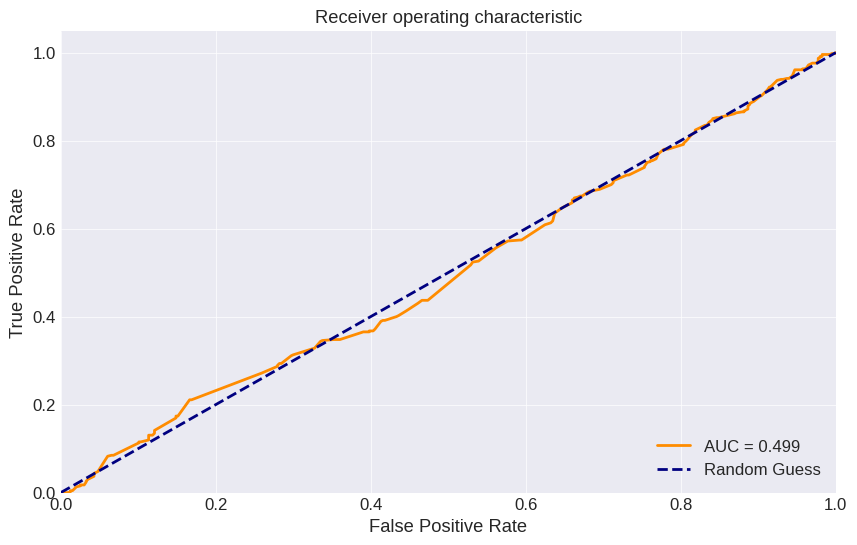

In [66]:
# Creating AdaBoostClassifier Model
model = AdaBoostClassifier(random_state = 42)

# Training and running predictions on the testing set
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:,1]
auc_score = roc_auc_score(y_test, y_pred)
print(f'\n Model AUC Score = {auc_score:.3f} \n')

# Plotting AUC-ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_score = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc_score:.3f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.style.use('seaborn-dark')
plt.grid(True)
plt.show()

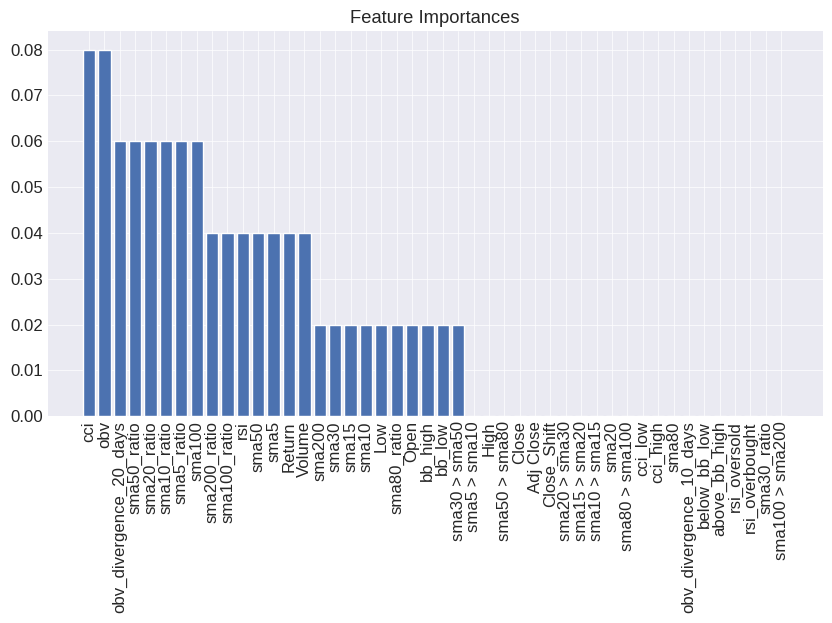

In [67]:
# Plotting Feature Importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.grid(True)
plt.show()

In [68]:
y_pred # Displaying probabilities


array([0.32559794, 0.32559794, 0.32507429, 0.3244441 , 0.32507429,
       0.32507429, 0.3244441 , 0.32507429, 0.3244441 , 0.32591672,
       0.3244441 , 0.32591672, 0.3244441 , 0.32518701, 0.32518701,
       0.32571075, 0.32571075, 0.32559794, 0.32507429, 0.3244441 ,
       0.3244441 , 0.32507429, 0.3244441 , 0.32507429, 0.3244441 ,
       0.3244441 , 0.32507429, 0.3244441 , 0.32507429, 0.3244441 ,
       0.3244441 , 0.32387112, 0.32387112, 0.32387112, 0.32450073,
       0.32387112, 0.32515736, 0.32450073, 0.32450073, 0.32387112,
       0.32387112, 0.32463408, 0.32537721, 0.32526446, 0.32463408,
       0.32526446, 0.32463408, 0.32526446, 0.32526446, 0.32387112,
       0.32450073, 0.32387112, 0.32463408, 0.32450073, 0.32463408,
       0.32590111, 0.32526446, 0.32537721, 0.32578827, 0.32478322,
       0.32578827, 0.32515736, 0.32526446, 0.32526446, 0.32463408,
       0.32463408, 0.32478322, 0.32653276, 0.32578827, 0.32578827,
       0.32526446, 0.32463408, 0.32450073, 0.32463408, 0.32537

In [69]:
quantile_intervals = np.arange(0, 1.125, 0.125) # Creating intervals for the quantiles
quantile_values = np.quantile(y_pred, quantile_intervals) # Dividing y_pred in 8 different quantiles
classes = pd.cut(y_pred, quantile_values) # Grouping probabilities according to the quantiles
X_test['y_true'] = y_test # Creating a new column in the X_test set containing the true label values
table = pd.crosstab(classes, X_test['y_true']) # Creating a table counting true labels according to each probability range
table

y_true,0,1
row_0,,
"(0.3201, 0.3241]",47,60
"(0.3241, 0.3246]",51,58
"(0.3246, 0.3251]",48,59
"(0.3251, 0.3252]",63,81
"(0.3252, 0.3255]",45,41
"(0.3255, 0.3258]",76,63
"(0.3258, 0.3261]",20,37
"(0.3261, 0.3293]",47,60


In [75]:
sign = np.zeros_like(y_pred) # Creating an array with 0s in the same length as y_pred

# Short selling signal
sign[((y_pred >= 0.3255) & (y_pred < 0.3258)) | ((y_pred > 0.3252) & (y_pred < 0.3258))] = -1

# Buying signal
sign[((y_pred >= 0.3251) & (y_pred <= 0.3252)) |
            ((y_pred >= 0.3201) & (y_pred <= 0.3241))] = 1

# Display signal values
sign

array([-1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  1., -1., -1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,
        1.,  1.,  0., -1., -1.,  0., -1.,  0., -1., -1.,  1.,  0.,  1.,
        0.,  0.,  0.,  0., -1., -1., -1.,  0., -1.,  1., -1., -1.,  0.,
        0.,  0.,  0., -1., -1., -1.,  0.,  0.,  0., -1.,  0.,  0., -1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0., -1.,  0.,
        0., -1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,
       -1.,  0., -1., -1.,  0.,  0., -1.,  0.,  0., -1.,  0.,  0.,  0.,
       -1.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1., -1., -1.,  1.,  0.,
       -1., -1.,  0.,  0., -1.,  0.,  0.,  0., -1., -1., -1.,  0., -1.,
        0.,  0., -1.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  1.,  0., -1.,  0.,  0.,  1., -1.,  0.,  1.,
        1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  0., -1

In [83]:
y_pred = np.random.rand(1000)  # Example predictions, replace this with your actual predictions

# Define the quantiles and calculate their values in y_pred
quantile_intervals = np.arange(0, 1.125, 0.125)
quantile_values = np.quantile(y_pred, quantile_intervals)

# Use pd.cut to categorize y_pred based on quantile ranges
categories = pd.cut(y_pred, quantile_values, include_lowest=True)

# Create an empty signal array
signals = np.zeros_like(y_pred)

# Define ranges for buy and sell signals based on quantiles
# Assuming quantile_values are sorted, which they should be
buy_ranges = [(quantile_values[0], quantile_values[2]), (quantile_values[3], quantile_values[4])]
sell_ranges = [(quantile_values[5], quantile_values[6]), (quantile_values[7], quantile_values[8])]

# Assign buy signals (1)
for low, high in buy_ranges:
    buy_signals = (y_pred >= low) & (y_pred < high)
    signals[buy_signals] = 1

# Assign sell signals (-1)
for low, high in sell_ranges:
    sell_signals = (y_pred >= low) & (y_pred < high)
    signals[sell_signals] = -1

# Example: Print the first 20 signals to check
print(signals[:20])

[ 0.  0.  0.  0.  0. -1. -1.  0.  0.  1.  1.  1.  0. -1. -1.  1.  0.  0.
 -1. -1.]


In [82]:
X_test['signals'] = signals # Creating new column

ValueError: Length of values (1000) does not match length of index (857)

In [84]:
X_test.head(8)

,Open,High,Low,Close,Adj Close,Volume,Close_Shift,Return,sma5,sma10,...,sma15 > sma20,sma20 > sma30,sma30 > sma50,sma50 > sma80,sma80 > sma100,sma100 > sma200,y_true,sign,position,model_returns
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-15,138.107498,140.057495,137.677505,139.699997,139.338165,26722400,140.587418,-0.888595,140.240314,138.187389,...,1,1,1,1,1,1,0,-1.0,NaN,NaN
2020-10-16,140.367493,141.214996,137.925003,138.115005,137.757248,24239200,139.338165,-1.134590,140.337555,138.934700,...,1,1,1,1,1,1,0,-1.0,-1.0,1.134590
2020-10-19,139.029999,139.835007,134.067505,134.977493,134.627884,29806800,137.757248,-2.271651,138.884833,138.790324,...,1,1,1,1,1,1,1,0.0,-1.0,2.271651
2020-10-20,135.835007,137.997498,135.070007,136.455002,136.101562,22921200,134.627884,1.094631,137.682455,138.699562,...,1,1,1,1,1,1,0,0.0,0.0,0.000000
2020-10-21,136.250000,137.914993,134.774994,135.247498,134.897171,21959600,136.101562,-0.884921,136.544406,138.261450,...,1,1,1,1,1,1,0,0.0,0.0,-0.000000
2020-10-22,135.225006,136.117493,132.317505,133.610001,133.263931,29048000,134.897171,-1.210729,135.329559,137.784937,...,1,1,1,1,1,1,1,0.0,0.0,-0.000000
2020-10-23,134.500000,135.932495,132.912506,135.902496,135.550476,23348400,133.263931,1.715802,134.888205,137.612880,...,1,1,1,1,1,1,0,0.0,0.0,0.000000
2020-10-26,134.270004,136.927505,130.384995,131.412506,131.072128,33689600,135.550476,-3.303823,134.177054,136.530943,...,1,1,1,1,1,1,1,0.0,0.0,-0.000000


In [85]:
X_test['position'] = X_test['sign'].shift(1) # Creating 'position' attribute
X_test['model_returns'] = X_test['position'] * X_test['Return'] # Creating 'daily returns' attribute for the strategy

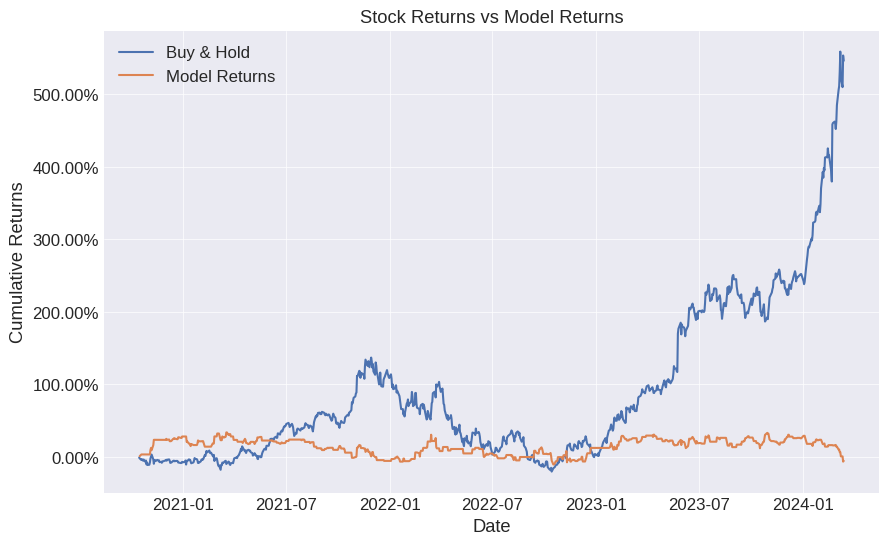


 Buy & Hold Cumulative Returns = 546.49% 
 Model Cumulative Returns = -5.42%


In [86]:
buy_and_hold_total_returns = (1 + X_test['Return'] / 100).cumprod()
buy_and_hold_total_returns = (buy_and_hold_total_returns - 1) * 100

# Computing model's cumulative returns
model_cumulative_returns = (1 + X_test['model_returns'] / 100).cumprod()
model_cumulative_returns = (model_cumulative_returns - 1) * 100

# Plotting line plot comparing Buy & Hold and Model
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(buy_and_hold_total_returns, label = 'Buy & Hold')
ax.plot(model_cumulative_returns, label = 'Model Returns')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Returns')
ax.set_title('Stock Returns vs Model Returns')

# Adding a '%' sign to the y-axis ticks
def percent_formatter(x, pos):
    return f'{x:.2f}%'
ax.yaxis.set_major_formatter(mtick.FuncFormatter(percent_formatter))

plt.style.use('seaborn-dark')
plt.grid(True)
plt.show()

# Printing results
print(f'\n Buy & Hold Cumulative Returns = {buy_and_hold_total_returns.iloc[-1]:.2f}% \n Model Cumulative Returns = {model_cumulative_returns.iloc[-1]:.2f}%')

[*********************100%%**********************]  1 of 1 completed


Model AUC Score: 0.508


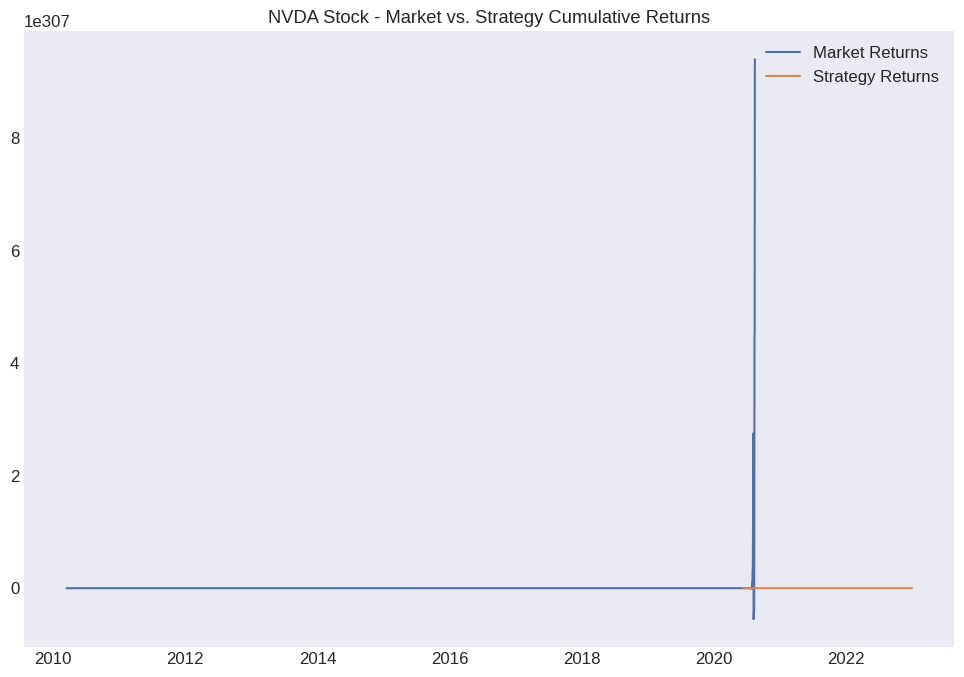

In [91]:
import numpy as np
import pandas as pd
import yfinance as yf
import ta
import quantstats as qs
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Fetch NVDA data
nvda = yf.download('NVDA', start='2010-01-01', end='2023-01-01')

# Calculate returns and shift close prices
nvda['Close_Shift'] = nvda['Adj Close'].shift(1)
nvda['Return'] = (nvda['Adj Close'] / nvda['Close_Shift'] - 1) * 100
nvda.dropna(inplace=True)

# Feature engineering (simplified example)
nvda['sma50'] = ta.trend.sma_indicator(nvda['Adj Close'], window=50)
nvda['rsi14'] = ta.momentum.RSIIndicator(nvda['Adj Close']).rsi()
nvda.dropna(inplace=True)

# Define the target variable
nvda['Target'] = np.where(nvda['Return'].shift(-1) > 0, 1, 0)
nvda.dropna(inplace=True)

# Define features
features = ['sma50', 'rsi14']
X = nvda[features]
y = nvda['Target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Train the model
model = AdaBoostClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict probabilities
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluate the model
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f'Model AUC Score: {auc_score:.3f}')

# Generate trading signals based on the threshold
threshold = 0.5
signals = np.where(y_pred_proba > threshold, 1, -1)

# Ensure signals are aligned with the test DataFrame
signals_aligned = pd.Series(signals, index=X_test.index)

# Backtest strategy
nvda.loc[signals_aligned.index, 'Strategy_Returns'] = nvda.loc[signals_aligned.index, 'Return'] * signals_aligned
nvda['Cumulative_Market_Returns'] = (nvda['Return'] + 1).cumprod() - 1
nvda['Cumulative_Strategy_Returns'] = (nvda['Strategy_Returns'] + 1).cumprod() - 1

# Plot cumulative returns
plt.figure(figsize=(12, 8))
plt.plot(nvda['Cumulative_Market_Returns'], label='Market Returns')
plt.plot(nvda['Cumulative_Strategy_Returns'], label='Strategy Returns')
plt.legend()
plt.title('NVDA Stock - Market vs. Strategy Cumulative Returns')
plt.show()

# Optionally, use quantstats to evaluate the strategy further
# qs.reports.html(nvda['Strategy_Returns'], benchmark=nvda['Return'])


In [92]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score
import yfinance as yf

# Load historical data for NVDA
nvda = yf.download('NVDA', start='2010-01-01', end='2023-03-24')

# Data preprocessing
nvda['Return'] = nvda['Adj Close'].pct_change()
nvda['Target'] = np.where(nvda['Return'].shift(-1) > 0, 1, 0)
nvda.dropna(inplace=True)

# Feature engineering
nvda['SMA20'] = nvda['Adj Close'].rolling(20).mean()
nvda['SMA50'] = nvda['Adj Close'].rolling(50).mean()
nvda['RSI'] = ...  # Calculate RSI using a library like ta
nvda['OBV'] = ...  # Calculate On-Balance Volume using a library like ta

# Split data into train and test sets
train = nvda.loc[nvda.index < '2020-01-01']
test = nvda.loc[nvda.index >= '2020-01-01']

X_train = train[['Return', 'SMA20', 'SMA50', 'RSI', 'OBV']]
y_train = train['Target']
X_test = test[['Return', 'SMA20', 'SMA50', 'RSI', 'OBV']]
y_test = test['Target']

# Train the model
model = AdaBoostClassifier()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred)
print(f'AUC Score: {auc_score:.3f}')

# Implement trading strategy
quantile_intervals = np.arange(0, 1.125, 0.125)
quantile_values = np.quantile(y_pred, quantile_intervals)
test['Prediction'] = pd.cut(y_pred, quantile_values, labels=False)

# Analyze the performance of the strategy
strategy_returns = []
for i in range(len(test)):
    if test['Prediction'].iloc[i] <= 1:  # Sell signal
        strategy_returns.append(-test['Return'].iloc[i])
    else:  # Buy signal
        strategy_returns.append(test['Return'].iloc[i])

strategy_returns = pd.Series(strategy_returns, index=test.index)
print(f'Cumulative Strategy Returns: {(strategy_returns + 1).cumprod().iloc[-1] * 100:.2f}%')

[*********************100%%**********************]  1 of 1 completed


ValueError: Input contains NaN